In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt

# Working with GRACE

In [2]:
# Loading the netcdf file
grace = xr.load_dataset("GRCTellus.JPL.200204_202311.GLO.RL06.1M.MSCNv03CRI.nc")
# Selecting relevant vars
grace_ds = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']]
grace_ds = grace_ds.rename({'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
#transforming the longitude coordinates
grace_ds = grace_ds.assign_coords(lon=np.sort(((grace_ds.lon + 180) % 360) - 180))
# grace_ds.lon.attrs = grace.lon.attrs
# grace_ds.lon.attrs["valid_min","valid_max"] = [min(grace_ds.lon.values),max(grace_ds.lon.values)]
# grace_ds.lon.attrs

AH = gpd.read_file("../Procesos/Shapefiles/Zonificacion_Hidrografica_2013/Area_hidrografica.shp")
Bounds = AH.geometry.bounds

In [3]:
GRACE = []
EARTH_RADIUS_KM = 6371
CM_TO_KM_RATIO = 1e-5
for i in range(AH.shape[0]):
    ds = grace_ds.where((grace_ds.lon > Bounds.iloc[i].minx) & (grace_ds.lon < Bounds.iloc[i].maxx)
                        &(grace_ds.lat > Bounds.iloc[i].miny) & (grace_ds.lat < Bounds.iloc[i].maxy))
    ds = ds.dropna(dim="lon",how="all")
    ds = ds.dropna(dim="lat",how="all")
#     df.sort_values(by='time', inplace=True)
    ds['surface_area_km2_0.5'] = EARTH_RADIUS_KM * np.radians(.5) * EARTH_RADIUS_KM * np.radians(.5) * np.cos(np.radians(ds['lat']))
    ds["lwe_thickness_km3"] = ds["lwe_thickness_cm"] * ds['scale_factor'] * CM_TO_KM_RATIO * ds['surface_area_km2_0.5']
    ds['uncertainty_km3'] = ds["uncertainty_cm"] * CM_TO_KM_RATIO * ds['surface_area_km2_0.5']
    GRACE.append(ds)
    del ds

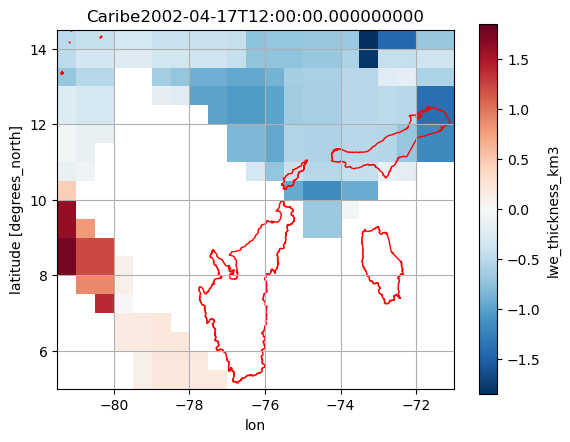

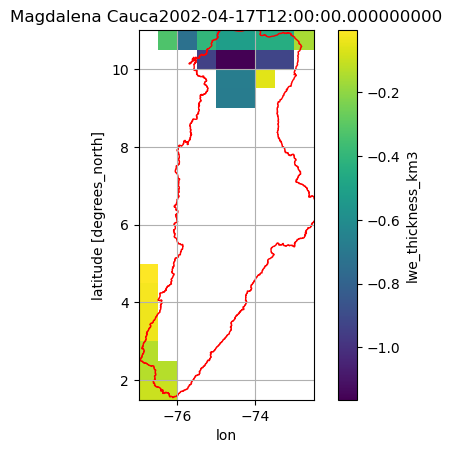

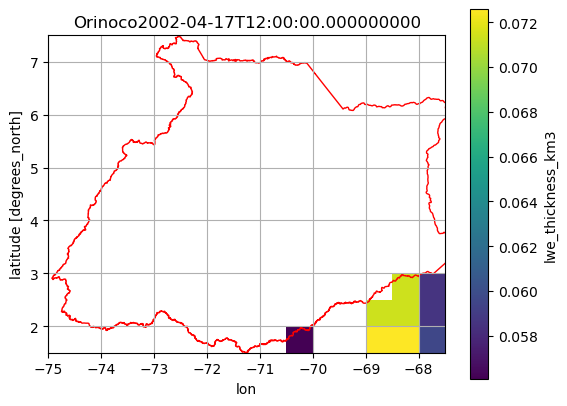

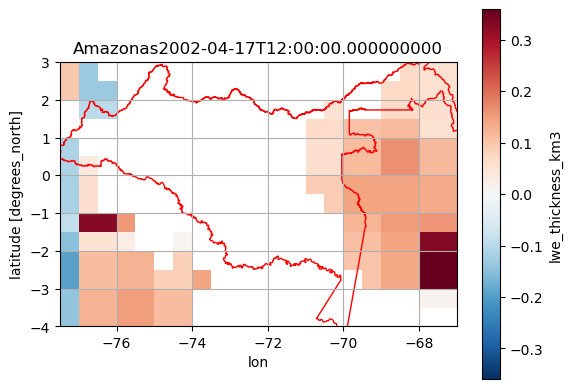

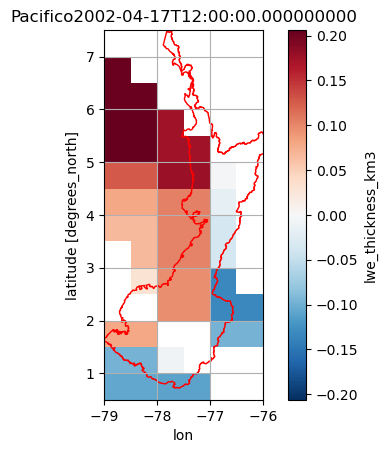

In [4]:
for i in range(len(GRACE)):
    fig , ax1 = plt.subplots()
    GRACE[i].lwe_thickness_km3[0].plot(ax=ax1)
    gpd.GeoSeries(AH.iloc[i].geometry).plot(ax=ax1,edgecolor="red",color="none")
    ax1.grid(True)
    plt.title(AH.iloc[i].NOM_AH+str(GRACE[i].time[0].values))
plt.show()

In [5]:
for i in range(len(GRACE)):
    GRACE[i].to_netcdf(os.path.join("./GRACE_DATA",AH.iloc[i].NOM_AH))